<a href="https://colab.research.google.com/github/hemanthpoojar21-maker/Uber-trip-analysis-project/blob/main/Uber_trip_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install xgboost --quiet

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost as xgb
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"Loaded file: {filename}")


Saving Uber-Jan-Feb-FOIL (1).csv to Uber-Jan-Feb-FOIL (1).csv
Loaded file: Uber-Jan-Feb-FOIL (1).csv


In [3]:
df.info()
display(df.head(10))
display(df.describe(include='all').T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB


,dispatching_base_number,date,active_vehicles,trips
0,B02512,01-01-2015,190,1132
1,B02765,01-01-2015,225,1765
2,B02764,01-01-2015,3427,29421
3,B02682,01-01-2015,945,7679
4,B02617,01-01-2015,1228,9537
5,B02598,01-01-2015,870,6903
6,B02598,01-02-2015,785,4768
7,B02617,01-02-2015,1137,7065
8,B02512,01-02-2015,175,875
9,B02682,01-02-2015,890,5506


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dispatching_base_number,354,6,B02512,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,354,59,01-01-2015,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
active_vehicles,354.0,NaN,NaN,NaN,1307.435028,1162.510626,112.0,296.75,1077.0,1417.0,4395.0
trips,354.0,NaN,NaN,NaN,11667.316384,10648.284865,629.0,2408.5,9601.0,13711.25,45858.0


In [4]:
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

if 'date' not in df.columns:
    raise ValueError("Expected a column named 'date' in the dataset.")

df['Date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

if 'trips' not in df.columns:
    raise ValueError("Expected a column named 'trips' in the dataset.")

df['Count'] = pd.to_numeric(df['trips'], errors='coerce').fillna(0)
df = df[['Date', 'Count']]
display(df.head())


/tmp/ipython-input-3129409801.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)


,Date,Count
0,2015-01-01,1132
1,2015-01-01,1765
2,2015-01-01,29421
3,2015-01-01,7679
4,2015-01-01,9537


In [5]:
df = df.set_index('Date').sort_index()
ts = df['Count'].resample('D').sum()
ts = ts.ffill().bfill()
print("Final series length:", len(ts))
display(ts.head())


Final series length: 43


,Count
Date,
2015-01-01,56437
2015-01-02,39189
2015-01-03,58449
2015-01-04,40798
2015-01-05,42752


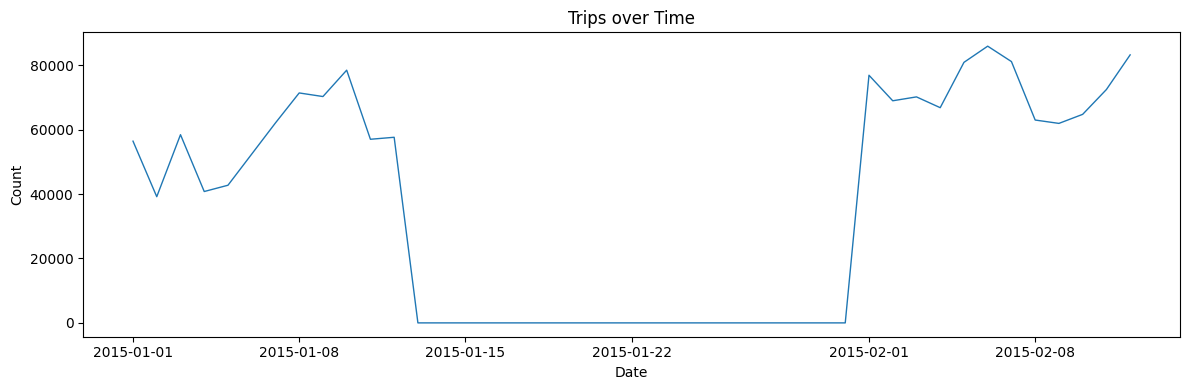

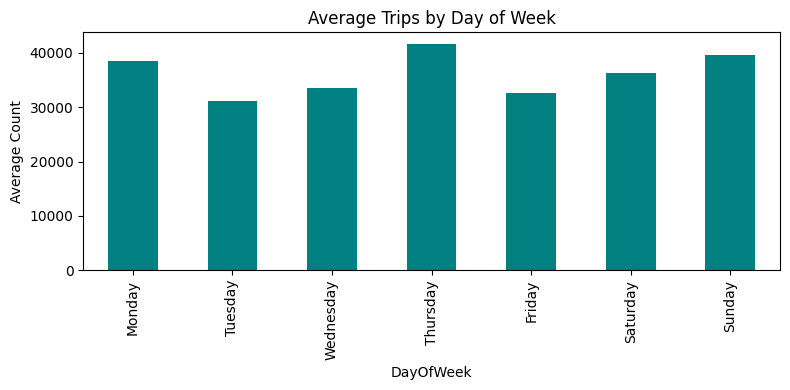

In [6]:
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, linewidth=1)
plt.title('Trips over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

df_plot = ts.reset_index()
df_plot['DayOfWeek'] = df_plot['Date'].dt.day_name()
plt.figure(figsize=(8,4))
df_plot.groupby('DayOfWeek')['Count'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).plot(kind='bar', color='teal')
plt.title('Average Trips by Day of Week')
plt.ylabel('Average Count')
plt.tight_layout()
plt.show()


In [7]:
def create_lagged_features(series, window):
    X, y, dates = [], [], []
    arr = series.values
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
        dates.append(series.index[i+window])
    return np.array(X), np.array(y), np.array(dates)

window = 7
X, y, dates = create_lagged_features(ts, window)
print("X shape:", X.shape, "y shape:", y.shape)
cols = [f'lag_{i}' for i in range(window,0,-1)]
X_df = pd.DataFrame(X, columns=cols, index=dates)
y_series = pd.Series(y, index=dates, name='Target')
display(X_df.head())


X shape: (36, 7) y shape: (36,)


,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1
2015-01-08,56437,39189,58449,40798,42752,52426,62102
2015-01-09,39189,58449,40798,42752,52426,62102,71413
2015-01-10,58449,40798,42752,52426,62102,71413,70296
2015-01-11,40798,42752,52426,62102,71413,70296,78484
2015-01-12,42752,52426,62102,71413,70296,78484,57026


In [8]:
split_idx = int(len(X_df) * 0.8)
X_train = X_df.iloc[:split_idx].values
y_train = y_series.iloc[:split_idx].values
X_test = X_df.iloc[split_idx:].values
y_test = y_series.iloc[split_idx:].values
dates_train = X_df.index[:split_idx]
dates_test = X_df.index[split_idx:]
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 28 Test size: 8


In [9]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {'n_estimators':[100,200], 'max_depth':[3,6], 'learning_rate':[0.05,0.1]}
tscv = TimeSeriesSplit(n_splits=3)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
print("Best XGBoost params:", xgb_grid.best_params_)
xgb_pred = xgb_best.predict(X_test)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
print("XGBoost MAPE:", xgb_mape)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
XGBoost MAPE: 0.24959079921245575


In [10]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_params = {'n_estimators':[100,200], 'max_depth':[5,15]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_)
rf_pred = rf_best.predict(X_test)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
print("Random Forest MAPE:", rf_mape)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best RF params: {'max_depth': 5, 'n_estimators': 200}
Random Forest MAPE: 0.16106745423317267


In [11]:
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_params = {'n_estimators':[100,200], 'learning_rate':[0.05,0.1], 'max_depth':[3,5]}
gbr_grid = GridSearchCV(gbr_model, gbr_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
gbr_grid.fit(X_train, y_train)
gbr_best = gbr_grid.best_estimator_
print("Best GBR params:", gbr_grid.best_params_)
gbr_pred = gbr_best.predict(X_test)
gbr_mape = mean_absolute_percentage_error(y_test, gbr_pred)
print("GBR MAPE:", gbr_mape)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best GBR params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
GBR MAPE: 0.13401431648242454


In [12]:
m_list = np.array([xgb_mape, rf_mape, gbr_mape])
recips = 1 / (m_list + 1e-12)
weights = recips / recips.sum()
print("Weights (XGB, RF, GBR):", weights)

ensemble_pred = weights[0]*xgb_pred + weights[1]*rf_pred + weights[2]*gbr_pred
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred)
print(f"Ensemble MAPE: {ensemble_mape:.4f}")

summary = pd.DataFrame({
    'Model': ['XGBoost','RandomForest','GradientBoosting','Ensemble'],
    'MAPE': [xgb_mape, rf_mape, gbr_mape, ensemble_mape]
})
display(summary)


Weights (XGB, RF, GBR): [0.22665339 0.35122304 0.42212357]
Ensemble MAPE: 0.1579


,Model,MAPE
0,XGBoost,0.249591
1,RandomForest,0.161067
2,GradientBoosting,0.134014
3,Ensemble,0.157947


XGBoost
 MAPE: 0.24959079921245575
 MSE: 463682496.0
 R2: -4.453080654144287

RandomForest
 MAPE: 0.16106745423317267
 MSE: 212194143.92581412
 R2: -1.4954827537397728

GradientBoosting
 MAPE: 0.13401431648242454
 MSE: 207618219.14474642
 R2: -1.4416681612995723

Ensemble
 MAPE: 0.1579466335981166
 MSE: 231942968.16065106
 R2: -1.7277363370521548



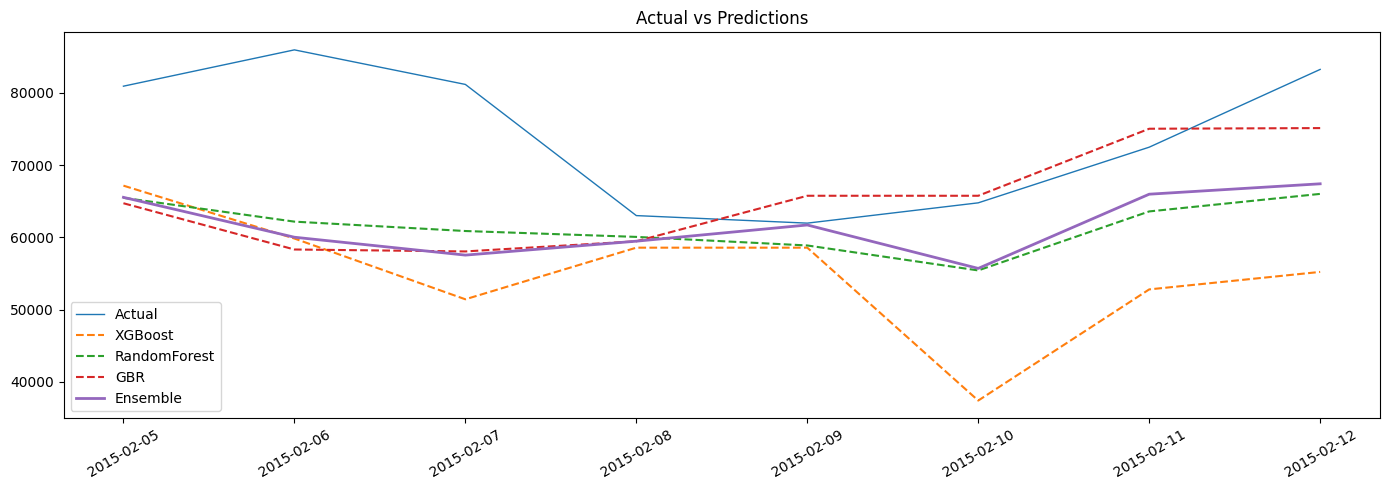

In [13]:
def print_metrics(y_true, y_pred, name):
    print(name)
    print(" MAPE:", mean_absolute_percentage_error(y_true, y_pred))
    print(" MSE:", mean_squared_error(y_true, y_pred))
    print(" R2:", r2_score(y_true, y_pred))
    print()

print_metrics(y_test, xgb_pred, "XGBoost")
print_metrics(y_test, rf_pred, "RandomForest")
print_metrics(y_test, gbr_pred, "GradientBoosting")
print_metrics(y_test, ensemble_pred, "Ensemble")

plt.figure(figsize=(14,5))
plt.plot(dates_test, y_test, label='Actual', linewidth=1)
plt.plot(dates_test, xgb_pred, '--', label='XGBoost')
plt.plot(dates_test, rf_pred, '--', label='RandomForest')
plt.plot(dates_test, gbr_pred, '--', label='GBR')
plt.plot(dates_test, ensemble_pred, '-', label='Ensemble', linewidth=2)
plt.legend()
plt.title('Actual vs Predictions')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [14]:
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(xgb_best, 'models/xgb_best.joblib')
joblib.dump(rf_best, 'models/rf_best.joblib')
joblib.dump(gbr_best, 'models/gbr_best.joblib')

summary.to_csv('models/model_mape_summary.csv', index=False)
pred_df = pd.DataFrame({
    'Date': dates_test,
    'Actual': y_test,
    'XGBoost': xgb_pred,
    'RandomForest': rf_pred,
    'GBR': gbr_pred,
    'Ensemble': ensemble_pred
})
pred_df.to_csv('models/predictions.csv', index=False)

print("Saved models and CSVs to /content/models")
from google.colab import files
files.download('models/model_mape_summary.csv')
files.download('models/predictions.csv')


Saved models and CSVs to /content/models


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>